<a href="https://colab.research.google.com/github/santiagorg2401/pytorch_course_exercises/blob/main/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA).
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Fri May  3 18:30:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code


2.2.1+cu121


## 1. What are 3 areas in industry where computer vision is currently being used?

1. Autonomous robots.
2. Security, facial recognition.
3. Factories.

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

Overfitting is when a model learns the learning patterns too well and fails to generalize, hence it struggles with test and foreign data. A sign of overfitting can be a higher accuracy in the training set and lower on the test set.

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each.
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

1. Diversify training data through having a larger dataset.
2. Regularization.
3. Data augmentation.

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [ ]:
import torchvision
from torchvision import datasets
train_data = datasets.MNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=torchvision.transforms.ToTensor(),
                                   target_transform=None)

test_data = datasets.MNIST(root="data",
                                  train=False,
                                  download=True,
                                  transform=torchvision.transforms.ToTensor(),
                                  target_transform=None)
class_names = train_data.classes

## 6. Visualize at least 5 different samples of the MNIST training dataset.

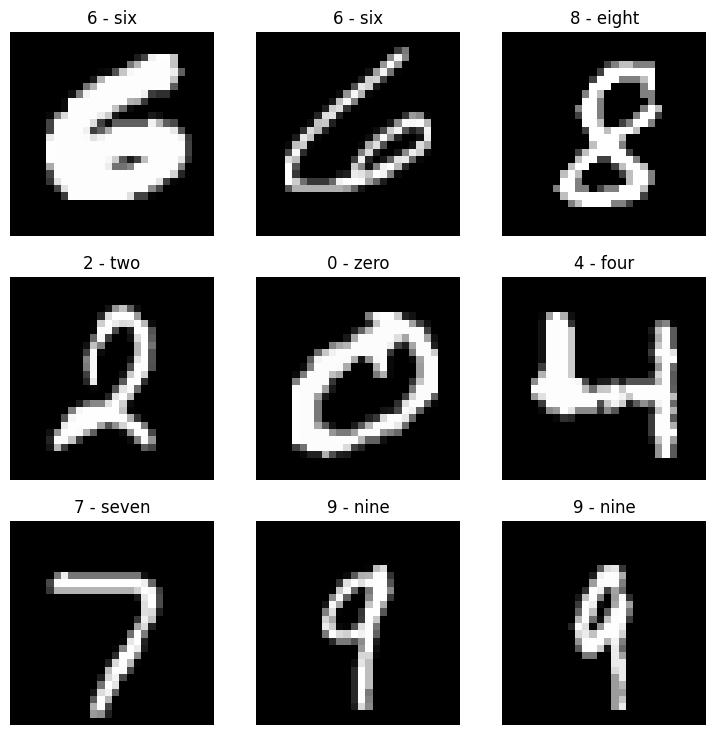

In [33]:
import matplotlib.pyplot as plt

SEED=42; W = 3; H = 3
torch.manual_seed(SEED)

fig = plt.figure(figsize=(9,9))
for i in range(1, W*H+1):
  rand_i = torch.randint(0, len(train_data), size=[1]).item()
  img, lbl = train_data[rand_i]
  fig.add_subplot(W, H, i)
  plt.imshow(torch.squeeze(img), cmap="gray")
  plt.axis(False)
  plt.title(class_names[lbl])

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [34]:
from torch.utils.data import DataLoader
BATCH = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH,
                             shuffle=True)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [35]:
from torch import nn
class MNISTModelV2(nn.Module):
  """
  TinyVGG architecture. Model from CNN explainer.
  """
  def __init__(self,
               input_shape:int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels= input_shape,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding= 1),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding= 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding= 1),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding= 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= hidden_units * 7 * 7,
                  out_features= output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [36]:
try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics
  from torchmetrics import Accuracy

In [37]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
  """Trains model with the dataset located on data_loader."""
  # Training loop
  train_loss, train_acc = 0, 0
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_pred.argmax(dim=1), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Calculate average loss and accuracy per epoch
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):
  """Tests model with the dataset located on data_loader."""
  # Testing loop
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(test_pred.argmax(dim=1), y)

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  return test_loss, test_acc

In [38]:
EPOCHS = 5; LR = 1e-2

device = "cpu"
torch.manual_seed(SEED)
model_2_cpu = MNISTModelV2(input_shape=1,
                                  hidden_units=10,
                                  output_shape=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2_cpu.parameters(),
                             lr=LR)
accuracy_fn = Accuracy(task="multiclass",
                       num_classes=len(class_names)).to(device)

for epoch in range(0, EPOCHS):
  train_loss, train_acc = train_step(model=model_2_cpu,
                                     data_loader=train_dataloader,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                     accuracy_fn=accuracy_fn,
                                     device=device)
  test_loss, test_acc = test_step(model=model_2_cpu,
                                  data_loader=test_dataloader,
                                  loss_fn=loss_fn,
                                  accuracy_fn=accuracy_fn,
                                  device=device)

In [39]:
device="cuda"
torch.manual_seed(SEED)
model_2_gpu = MNISTModelV2(input_shape=1,
                                  hidden_units=10,
                                  output_shape=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2_gpu.parameters(),
                             lr=LR)
accuracy_fn = Accuracy(task="multiclass",
                       num_classes=len(class_names)).to(device)

for epoch in range(0, EPOCHS):
  train_loss, train_acc = train_step(model=model_2_gpu,
                                     data_loader=train_dataloader,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                     accuracy_fn=accuracy_fn,
                                     device=device)
  test_loss, test_acc = test_step(model=model_2_gpu,
                                  data_loader=test_dataloader,
                                  loss_fn=loss_fn,
                                  accuracy_fn=accuracy_fn,
                                  device=device)

## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [40]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Pass data to cpu
      pred_probs.append(pred_prob.to("cpu"))

  return torch.stack(pred_probs)

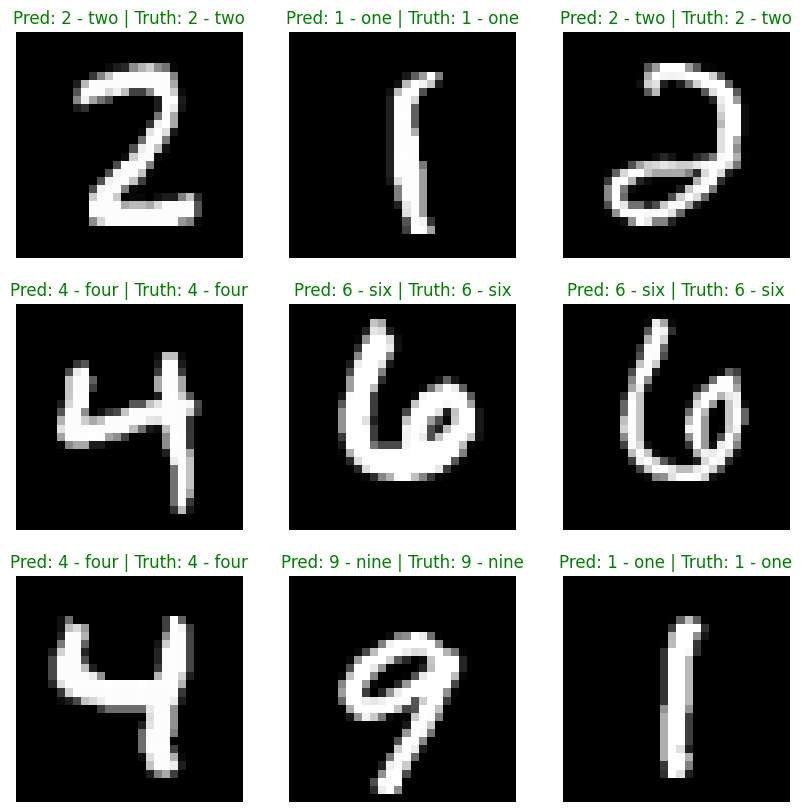

In [41]:
import random

W = 3; H = 3
random.seed(SEED)
test_samples = []
test_labels = []

# Get random samples from test dataset
for sample, label in random.sample(list(test_data), k=W*H):
  test_samples.append(sample)
  test_labels.append(label)

# Make predictions
pred_probs = make_predictions(model=model_2_gpu,
                              data=test_samples,
                              device=device)
pred_classes = pred_probs.argmax(dim=1)

plt.figure(figsize=(10, 10))
for i, sample in enumerate(test_samples):
  plt.subplot(H, W, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  plt.axis(False)
  pred_lbl = class_names[pred_classes[i]]
  truth_lbl = class_names[test_labels[i]]
  m = f"Pred: {pred_lbl} | Truth: {truth_lbl}"
  if pred_lbl == truth_lbl:
    plt.title(m, c="g")
  else:
    plt.title(m, c="r")

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

Making predictions ...:   0%|          | 0/313 [00:00<?, ?it/s]

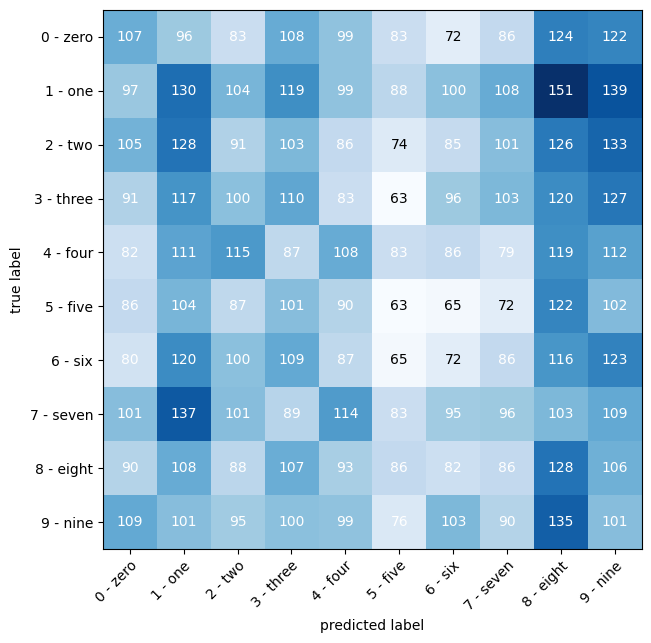

In [42]:
import mlxtend

from tqdm.auto import tqdm
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Make predictions and save them in a tensor
y_preds = []
model_2_gpu.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions ..."):
    X, y = X.to(device), y.to(device)
    y_logit = model_2_gpu(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)
fig, ax = plot_confusion_matrix(conf_mat= confmat_tensor.numpy(),
                                class_names= class_names,
                                figsize=(10, 7))

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [44]:
rand_tensor = torch.rand([1, 3, 64, 64])

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=10,
                   kernel_size=2)
conv2d(rand_tensor)

tensor([[[[ 7.8760e-02,  7.4272e-01,  4.2356e-01,  ...,  1.5065e-01,
            1.6461e-01,  3.8097e-01],
          [ 3.9301e-01,  8.9071e-02,  3.6358e-02,  ...,  2.6936e-01,
            9.6290e-02,  4.2744e-01],
          [-1.7945e-01,  2.8466e-01,  3.4659e-01,  ...,  2.8925e-01,
            5.4418e-01,  3.0495e-01],
          ...,
          [ 1.7013e-01,  1.5508e-01,  3.0603e-01,  ...,  2.4316e-01,
            1.5831e-01,  3.9577e-01],
          [ 7.2507e-01,  3.5084e-01,  2.6328e-01,  ...,  6.0521e-01,
            4.1127e-01,  3.0796e-01],
          [ 2.2910e-01,  2.7342e-01,  2.2231e-01,  ...,  2.2873e-01,
           -3.3992e-02,  1.4898e-01]],

         [[-6.0284e-01, -4.1378e-01, -6.5110e-01,  ..., -3.5632e-01,
           -6.5020e-01, -5.8941e-01],
          [-2.8341e-01, -5.5582e-01, -5.6745e-01,  ..., -5.2044e-01,
           -4.5677e-01, -3.2581e-01],
          [-6.2133e-01, -5.0083e-01, -8.3914e-01,  ..., -4.7899e-01,
           -5.2996e-01, -4.0182e-01],
          ...,
     

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?